In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
import math
from matplotlib import animation, rc
from IPython.display import HTML

In [4]:
def imshow_list(l, scale=1.0):
  if scale == 1.0:
    fig = plt.figure()
  else:
    fig = plt.figure(figsize=(scale*7,scale*4))
  for i, im in enumerate(l):
    try:
      im = im.cpu().detach().squeeze().squeeze().squeeze()
    except:
      pass
    im = im.squeeze()
    plt.subplot(1,len(l),i+1)
    #plt.tight_layout()
    plt.imshow(im, cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

  plt.show()

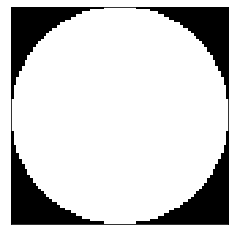

In [5]:
scaling_factor = 8
ball_dim = scaling_factor*10
canvas_dim = scaling_factor*32
small_canvas_dim = int(canvas_dim/scaling_factor)
radius = ball_dim/2
ball = np.zeros((ball_dim, ball_dim))

for i in range(ball_dim):
  for j in range(ball_dim):
    if (i+0.5-radius)**2 + (j+0.5-radius)**2 <= radius**2:
      ball[i,j] = 1.0

ball_canv = np.expand_dims(ball,0)
imshow_list(ball_canv)

In [6]:
def draw_ball(canvas, position):
  canvas[
    0,
    int(position[0]+0.5-radius):int(position[0]+0.5+radius),
    int(position[1]+0.5-radius):int(position[1]+0.5+radius)
  ] += ball
  canvas = canvas.clip(0, 1)
  return canvas

In [7]:
def random_positions(n, canvas_dim):
  positions = []
  i = 0
  while i < n:
    (x,y) = (radius+(canvas_dim-ball_dim)*random.random(), radius+(canvas_dim-ball_dim)*random.random())
    collision = False
    for (prev_x, prev_y) in positions:
      if (x-prev_x)**2 + (y-prev_y)**2 <= ball_dim**2:
        collision = True
        break

    if not collision:
      positions.append((x,y))
      i += 1
      
  return positions

In [8]:
def draw_canvas(positions):
  canvas = np.zeros((canvas_dim, canvas_dim))
  canvas = np.expand_dims(canvas,0)
  for pos in positions:
    canvas = draw_ball(canvas, pos)
    
  old_canvas = canvas
  canvas = np.zeros((small_canvas_dim, small_canvas_dim))
  canvas = np.expand_dims(canvas,0)
  for i in range(small_canvas_dim):
    for j in range(small_canvas_dim):
      canvas[0,i,j] = old_canvas[0,scaling_factor*i:scaling_factor*(i+1), scaling_factor*j:scaling_factor*(j+1)].mean()
    
  return canvas

In [9]:
def argmin(l):
  m = min(l)
  argm = -1
  for i in range(len(l)):
    if l[i] <= m:
      argm = i
      
  return m, argm

In [10]:
def events_times(positions, velocities):
  times = []
  for i in range(n):
    if velocities[i][0] < 0:
      times.append(-(positions[i][0]-radius)/velocities[i][0])
    else:
      times.append((canvas_dim-positions[i][0]-radius)/velocities[i][0])
    if velocities[i][1] < 0:
      times.append(-(positions[i][1]-radius)/velocities[i][1])
    else:
      times.append((canvas_dim-positions[i][1]-radius)/velocities[i][1])
    for j in range(i):
      c1 = positions[i][0]-positions[j][0]
      c2 = positions[i][1]-positions[j][1]
      c3 = velocities[i][0]-velocities[j][0]
      c4 = velocities[i][1]-velocities[j][1]
      A = c3**2 + c4**2
      B = 2*(c1*c3+c2*c4)
      C = c1**2+c2**2-ball_dim**2
      discriminant = B**2-4*A*C
      if discriminant >= 0 and min((-B+math.sqrt(discriminant))/(2*A), (-B-math.sqrt(discriminant))/(2*A)) >= 0:
        times.append(min((-B+math.sqrt(discriminant))/(2*A), (-B-math.sqrt(discriminant))/(2*A)))
      else:
        times.append(float('inf'))
    
  return times


def do_event(positions, velocities, index):
  for i in range(n):
    if index == 0:
      velocities[i] = (-velocities[i][0], velocities[i][1])
      return velocities
    index -= 1
    if index == 0:
      velocities[i] = (velocities[i][0], -velocities[i][1])
      return velocities
      
    index -= 1
    for j in range(i):
      if index == 0:
        c = ((velocities[i][0]-velocities[j][0])*(positions[i][0]-positions[j][0]) + \
            (velocities[i][1]-velocities[j][1])*(positions[i][1]-positions[j][1])) / \
            ((positions[i][0]-positions[j][0])**2 + (positions[i][1]-positions[j][1])**2)
        
        velocities[i] = (
          velocities[i][0]-c*(positions[i][0]-positions[j][0]),
          velocities[i][1]-c*(positions[i][1]-positions[j][1])
        )
        velocities[j] = (
          velocities[j][0]-c*(positions[j][0]-positions[i][0]),
          velocities[j][1]-c*(positions[j][1]-positions[i][1])
        )
        return velocities
        
      index -= 1
    
  return velocities

In [11]:
def simple_step(positions, velocities, t):
  new_positions = []
  for i in range(len(positions)):
    new_positions.append((positions[i][0]+velocities[i][0]*t, positions[i][1]+velocities[i][1]*t))
    
  return new_positions


def step(positions, velocities, t):
  times = events_times(positions, velocities)
  min_t, index = argmin(times)
  if min_t >= t:
    return simple_step(positions, velocities, t), velocities
  else:
    positions = simple_step(positions, velocities, min_t)
    velocities = do_event(positions, velocities, index)
    return step(positions, velocities, t-min_t)

In [12]:
def random_init(n, velocity_min, velocity_max):
  positions = random_positions(n, canvas_dim)
  velocities = []
  for i in range(n):
    magnitude = velocity_min+(velocity_max-velocity_min)*random.random()
    angle = 2*math.pi*random.random()
    velocities.append((magnitude*math.cos(angle), magnitude*math.sin(angle)))

  return positions, velocities

#### 
#### Generate an example animation of 50 frames:

In [ ]:
n = 3
velocity_min = 20
velocity_max = 30
positions, velocities = random_init(n, velocity_min, velocity_max)
no_frames = 50
canvases = []
for i in range(no_frames):
  canvas = draw_canvas(positions)
  canvases.append(canvas)
  imshow_list([canvas], scale=0.2)
  positions, velocities = step(positions, velocities, 1.)

In [ ]:
fig, ax = plt.subplots();
plt.xticks([]);
plt.yticks([]);

In [68]:
def animate(i):
    im.set_data(canvases[i].squeeze(0))
    return (im,)

anim = animation.FuncAnimation(fig, animate, frames=no_frames, interval=100)
im = ax.imshow(canvases[0].squeeze(0), cmap='gray', interpolation='none')
HTML(anim.to_html5_video())

In [69]:
anim.save('./real_anim.gif', writer='imagemagick', fps=10)

#### 
#### Generate a dataset of 100,000 animations, each with 4 frames:

In [ ]:
no_anims = 100000
no_frames = 4
shift_time = 20
n = 3
velocity_min = 20
velocity_max = 30
dat = None
dat = np.empty((no_anims, no_frames, small_canvas_dim, small_canvas_dim))
for i in range(no_anims):
  positions, velocities = random_init(n, velocity_min, velocity_max)
  positions, velocities = step(positions, velocities, shift_time)
  for j in range(no_frames):
    dat[i,j,:] = draw_canvas(positions)
    positions, velocities = step(positions, velocities, 1.)
    
  
  if i % 500 == 0:
    print(i)

print(dat.shape)

#### 
#### Plot sample animations:

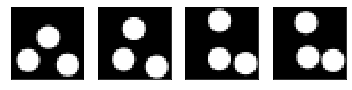

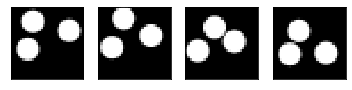

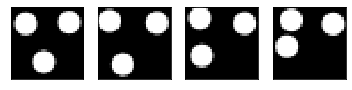

In [38]:
for i in range(3):
  ind = int(no_anims*random.random())
  imshow_list([dat[ind][0], dat[ind][1], dat[ind][2], dat[ind][3]])
  print('')


#### Save the dataset:

In [38]:
print('Saving...')
np.savez_compressed('ball_collisions.npz', array1=dat)
print('Done!')

Saving...
Done!


#### 
#### Ensure the dataset loads successfully:

In [35]:
print('Loading...')
dat = None
dat = np.load('ball_collisions.npz', allow_pickle=True)
dat = dat['array1']
print('Done!')
print(dat.shape)

Loading...
Done!
(100000, 4, 32, 32)
